In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d

ann_arr = load_model('IP_Arrival_time/Arrival_ANN_1')
ann_end = load_model('IP_End_time/End_ANN_2')
ann_chg = load_model('IP_Change_time/Change_ANN_3')

#Section1
ann1 = load_model('IP_Section_1_new/Section1_ANN_3')
sc1 = pickle.load(open('IP_Section_1_new/Section1_scaler_ANN_3.pkl', 'rb'))
#Section2
ann2 = load_model('IP_Section_2_new/Section2_new_ANN_5')
sc2 = pickle.load(open('IP_Section_2_new/Section2_new_scaler_ANN_5.pkl', 'rb'))
#Section3
ann3 = load_model('IP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('IP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('IP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('IP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('IP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('IP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('IP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('IP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at you

In [34]:
charge_mass = 16.2
standoff_distance = 26.3
start_time = 55
termination_time = 110
interval = 0.01

In [35]:
arr = np.array ([[charge_mass,standoff_distance]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
print ("end", end_time, "change", change_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:3] = sc1.transform(d_set[:,0:3])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:3] = sc2.transform(d_set[:,0:3])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:3] = sc3.transform(d_set[:,0:3])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:3] = sc4.transform(d_set[:,0:3])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:3] = sc5.transform(d_set[:,0:3])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:3] = sc6.transform(d_set[:,0:3])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

if termination_time < arrival_time:
    start = start_time
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = start_time
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(charge_mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(standoff_distance, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)

p2, section = p_fluctuation(standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
print (section)

X1 = ml_model[:,0]
y1 = ml_model[:,1]

1/1 [==============================] - 0s 32ms/step
end [[102.570366]] change [[71.20472]]
127/127 [==============================] - 0s 2ms/step
6


In [36]:
file_path = f'G:/Chamodi/Machine_Learning/Pressure_history_2/IP_Num&ANN_Comparison/LSDYNA/{charge_mass}kg/{standoff_distance}m.xlsx'
lsdyna = pd.read_excel(file_path)
#lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])
X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']
X2_original=X2_original*1000
y2_original=(y2_original/1000)-101.25

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2 = X2_original[index1:index2+1]
y2 = y2_original[index1:index2+1]

X2 = X2.to_numpy()
y2 = y2.to_numpy()

print("Numerical length",len(y2), "ANN-based length", len(y1))

Numerical length 5502 ANN-based length 5504


Integrated Area Under the Curve: -9.430053609687818, 4.492005491479254


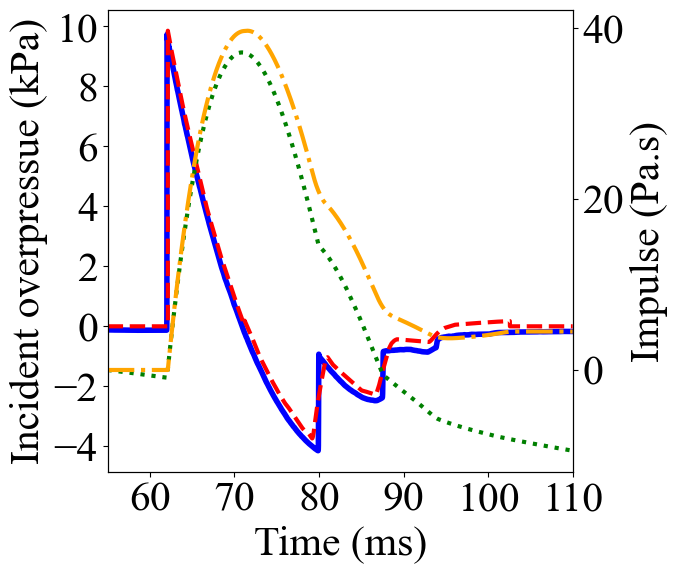

In [37]:
# Perform numerical integration using the trapezoidal rule
area_num = np.trapz(y2, X2)
area_ann = np.trapz(y1, X1)
print(f"Integrated Area Under the Curve: {area_num}, {area_ann}")

# Perform cumulative integration using the trapezoidal rule
ci_num = np.cumsum(np.gradient(X2) * y2)
ci_ann = np.cumsum(np.gradient(X1) * y1)

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.rcParams["font.family"] = "Times New Roman"

# Plot the original data (y vs time) on the primary y-axis
ax1.plot(X2, y2, color = 'blue',label = 'Numerical - Overpressure', linewidth=4)
ax1.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework - Overpressure', linewidth=3)
ax1.set_xlabel('Time (ms)', fontsize = 30)
ax1.set_ylabel('Incident overpressue (kPa)', fontsize = 30)
ax1.tick_params(axis='both', labelsize = 30)
ax1.set_xticks([60, 70, 80, 90, 100, 110])
ax1.set_yticks([-4, -2, 0, 2, 4, 6, 8, 10])
ax1.set_xlim(start_time,termination_time)
#ax1.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2), fontsize=30, ncol=1, frameon = False)

# Create a secondary y-axis for the cumulative integration
ax2 = ax1.twinx()
ax2.plot(X2, ci_num, color='green', linestyle='dotted',label='Numerical - Impulse', linewidth=3)
ax2.plot(X1, ci_ann, linestyle='dashdot', label='ANN framework - Impulse', color='orange', linewidth=3)
ax2.set_ylabel('Impulse (Pa.s)', fontsize = 30)
#ax2.set_yticks([0,10,20,30,40,50])
ax2.tick_params(axis='both', labelsize = 30)
#ax2.legend(loc='upper center', bbox_to_anchor=(0.3, -0.45), fontsize=30, ncol=1, frameon = False)

plt.savefig(f'IP_Num&ANN_Comparison/Images2/Section{section}/{standoff_distance}m{charge_mass}kg_new.png', dpi=150, bbox_inches='tight')
plt.show()